# MATERNAL HEALTH RISK PREDICTION

Assessing Pregnancy Risks: EDA, Modeling, and Hypothesis Testing

 <p>Este cuaderno está inspirado en el Trabajo de :<a href="https://www.kaggle.com/code/annastasy/pregnancy-risks-eda-modeling-hypothesis#Assessing-Pregnancy-Risks:-EDA,-Modeling,-and-Hypothesis-Testing" title="Pregnancy Risk">
este notebook de pregnancy risk prediction</a>.</p>

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


import scipy.stats as stats 
from scipy.stats import chi2_contingency, boxcox

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm 

In [5]:
import warnings
warnings.filterwarnings("ignore")

## Vamos a entender nuestros datos y entender el papel de las etiquetas risk

In [17]:
df= pd.read_csv("Maternal Health Risk Data Set.csv")
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


Miramos duplicados:

In [25]:
df[df.duplicated(keep='first')]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
67,19,120,80,7.0,98.0,70,mid risk
72,19,120,80,7.0,98.0,70,mid risk
97,19,120,80,7.0,98.0,70,mid risk
106,50,140,90,15.0,98.0,90,high risk
107,25,140,100,6.8,98.0,80,high risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


Observamos si hay mujeres menores a 13 años y mayores de 60, ya que no son fertiles. 

In [37]:
print(f"número de mujeres mayores de 60 años: {len(df[df.Age > 60])} y el número de mujeres menores de 13 es {len(df[df.Age < 13])}")


número de mujeres mayores de 60 años: 8 y el número de mujeres menores de 13 es 39


Exploramos la cantidad de mujeres con baja frecuencia cardíaca: 

In [41]:
df[df.HeartRate < 60]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
499,16,120,75,7.9,98.0,7,low risk
908,16,120,75,7.9,98.0,7,low risk


**Principales Hipótesis**

<ul>
    <li>Tenemos 1014 entradas y 7 variables.</li>
    <li>las primeras 5 columnas como ya vimos en el notebook <code>wearable_sintetico</code> sonn tipo int menos dos float.</li>
    <li>La columna de RiskLevel es un objeto y para el algoritmo de ML hay que pasarlo a tipo numérico.</li>
    <li>No hay valores nulos.</li>
    <li>Hay muchas filas duplicadas.</li>
    <li>El rango de edad es desde los 10 a los 70 años. Aunque no sea legal en Europa, hay niñas con capacidad de quedarse
    embarazadas a los 10 años en otros países.</li>
</ul>

## Limpieza de los datos

In [57]:
data = df.copy()

In [65]:
data = data.drop_duplicates().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          452 non-null    int64  
 1   SystolicBP   452 non-null    int64  
 2   DiastolicBP  452 non-null    int64  
 3   BS           452 non-null    float64
 4   BodyTemp     452 non-null    float64
 5   HeartRate    452 non-null    int64  
 6   RiskLevel    452 non-null    object 
dtypes: float64(2), int64(4), object(1)
memory usage: 24.8+ KB


Ahora vemos que hemos pasado de 1014 entradas a 452. 

## CODIFICACIÓN DE CARACTERÍSTICAS PARA VARIABLES CATEGÓRICAS

La columna HeartRate es ordinal, es decir, toma valores en categorías ordenadas. 
Para ello hacemos una codificación de etiquetas, donde los valores se asignan manualmente a las
claves correspondientes, usando la función <code>replace()</code>

In [70]:
data.replace({"high risk":2, "mid risk": 1, "low risk": 0}, inplace=True)
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
2,29,90,70,8.0,100.0,80,2
3,30,140,85,7.0,98.0,70,2
4,35,120,60,6.1,98.0,76,0


## MANEJO DE OUTLIERS

Vamos a verificar si se encuentran dentro del rango de las medidas fisiológicas, tal y como hemos hecho 
anteriormente. Tras ello, en esta misma sección se mostrarán los outliers de cada variable y se 
evaluará si es necesario eliminarlos o no, ya que pueden ser un signo de alguna condición 
en la que estemos interesados (véase preeclampsia o diabates o alguna infección puntual en caso de la temperatura).

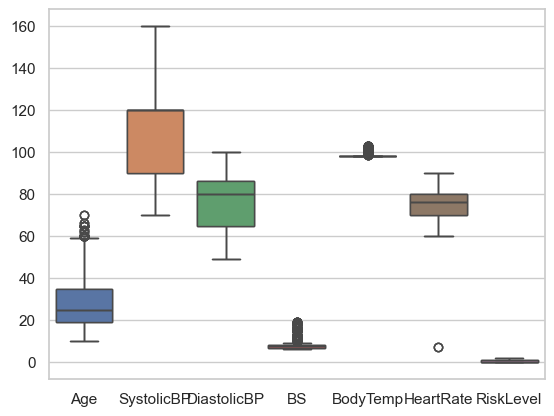

In [110]:
sns.boxplot(data=data)
plt.show()

Como vemos sólo hay outliers en la edad y en los niveles de la glucosa. Pese a esto no vamos a eliminar
los outliers ya que nos interesan para que nuestro algoritmo a que edades o niveles de glucosa haybriesgo.

## Exploratory Data Analysis

### Análisis Univariante y Bivariante

<ol>
    <li>Age Vs. Risk Level</li>
    <li>Blood Glucose Level Vs. Risk Level</li>
    <li>Blood Pressure Vs. Risk Level </li>
</ol>


**Age Vs Risk Level**

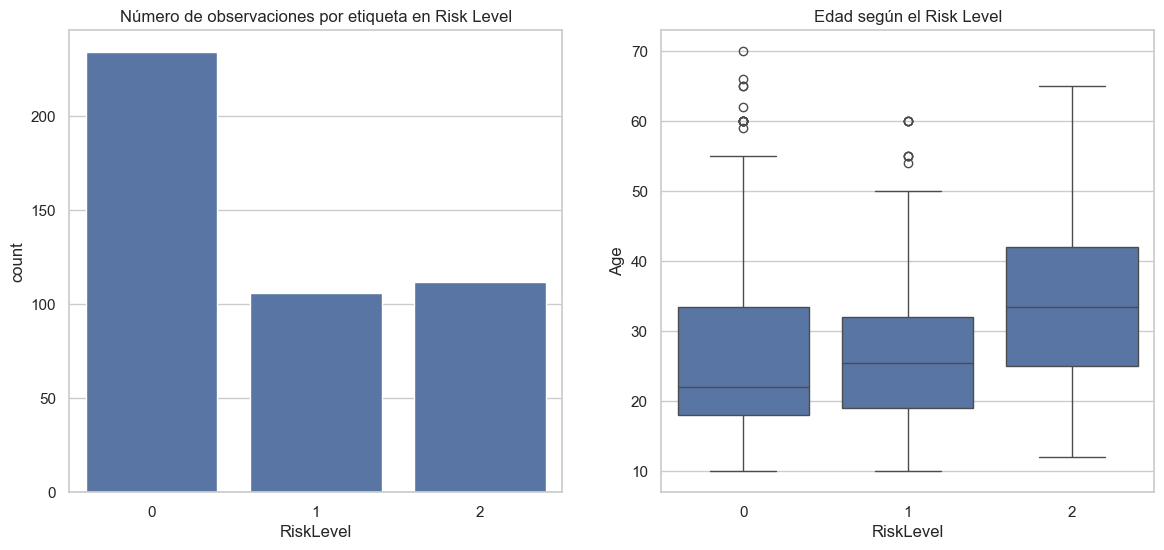

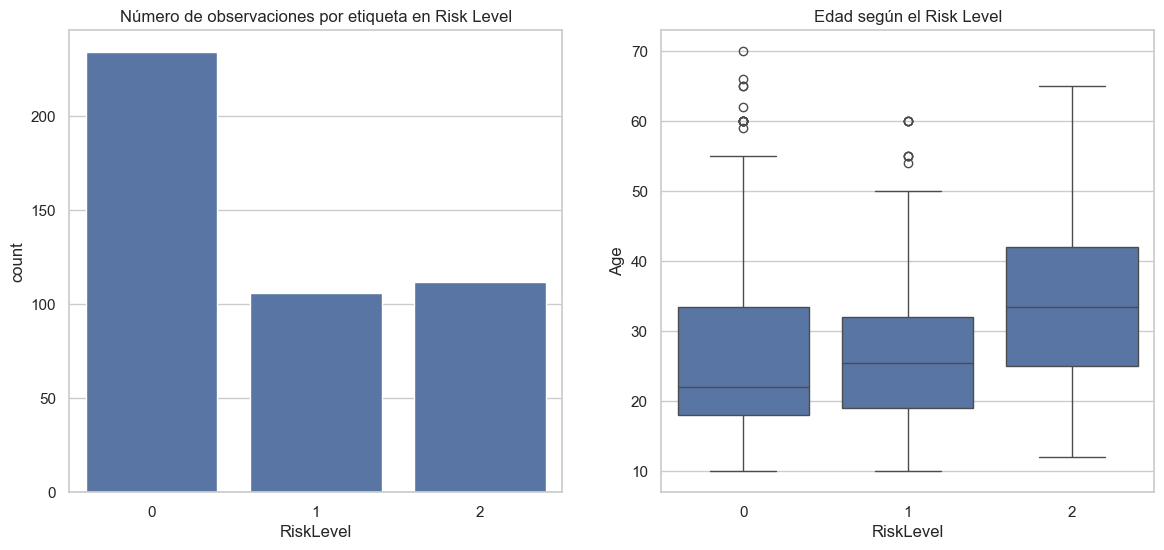

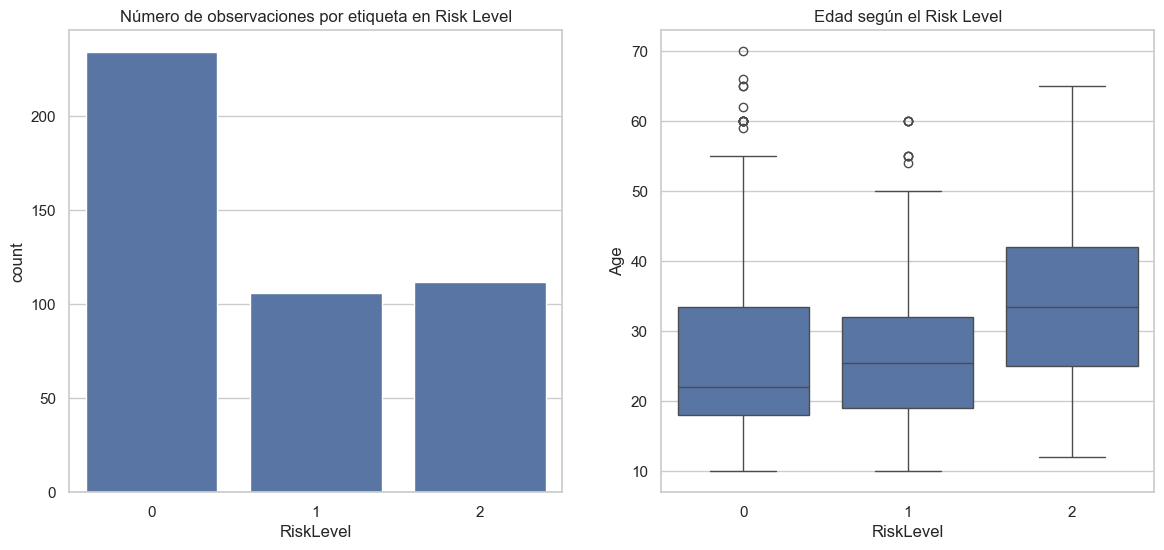

In [120]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,6))

sns.countplot(ax=axes[0], x=data.RiskLevel)
axes[0].set_title("Número de observaciones por etiqueta en Risk Level")

sns.boxplot(ax=axes[1], x=data.RiskLevel, y=data.Age)
axes[1].set_title("Edad según el Risk Level");
plt.show()

Como podemos ver, hay muchas mujeres diagnosticadas de bajo riesgo. En la realidad lo normal es que
un embarazo salga bien o no presente complicaciones que lo ponga en peligro. 
Si miramos el gráfico de la derecha, podemos observar que la mayoría de los embarazos de bajo y moderado riesgo, 
se encuentran en edades más tempranas. En cambio, la media de edad de las mujeres que presentan mayor riesgo es aproximadamente
35 años. De ello podemos esperar que sí hay una relación entre Edad y Nivel de Riesgo. 

**Glucose Level Vs. Risk Level**

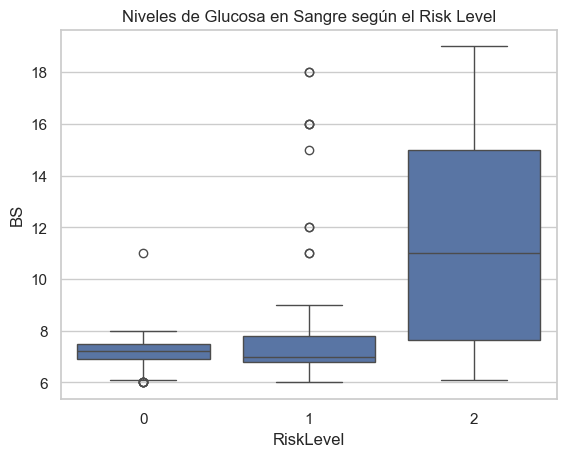

In [150]:
sns.boxplot(x=data.RiskLevel, y=data.BS).set_title("Niveles de Glucosa en Sangre según el Risk Level")
plt.show()

Como se esperaba, según aumentan los niveles de glucosa, aumenta el nivel de riesgo. 
Podemos considerar la glucosa en sangre como un factor predictivo importante para evaluar el 
nivel de riesgo. 

**Blood Pressure Vs. Risk Level**

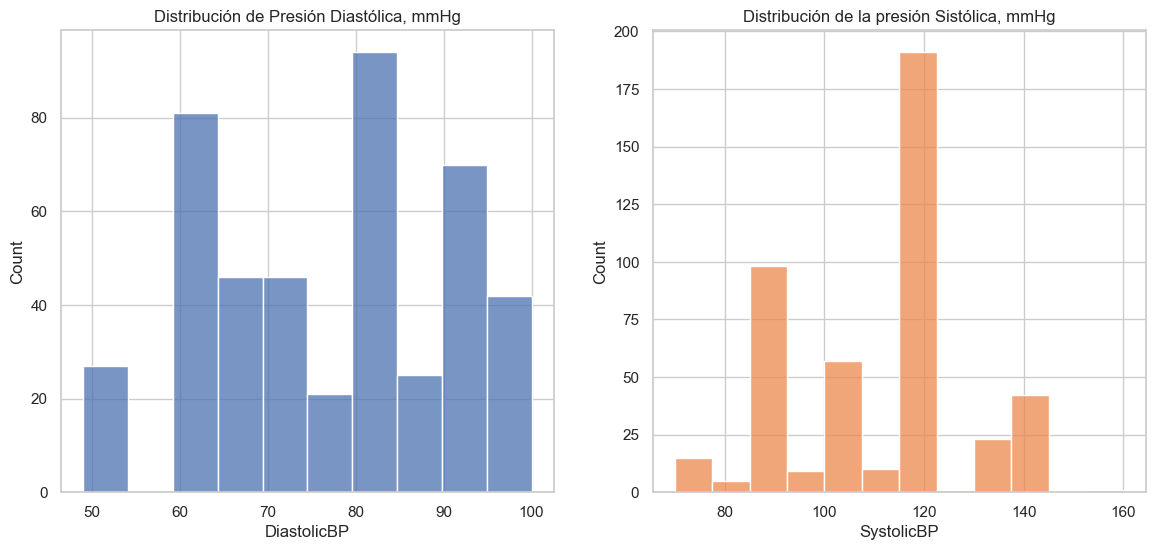

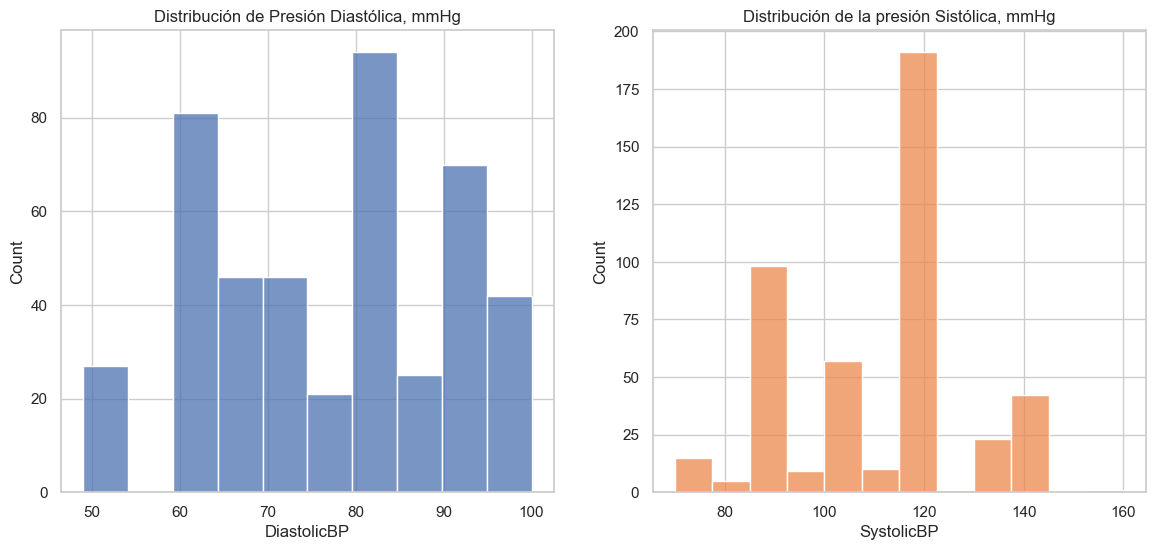

In [132]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,6))

sns.histplot(ax=axes[0], x=data.DiastolicBP)
axes[0].set_title("Distribución de Presión Diastólica, mmHg")

sns.histplot(ax=axes[1], x=data.SystolicBP, color="#ed894e")
axes[1].set_title("Distribución de la presión Sistólica, mmHg")
plt.show()

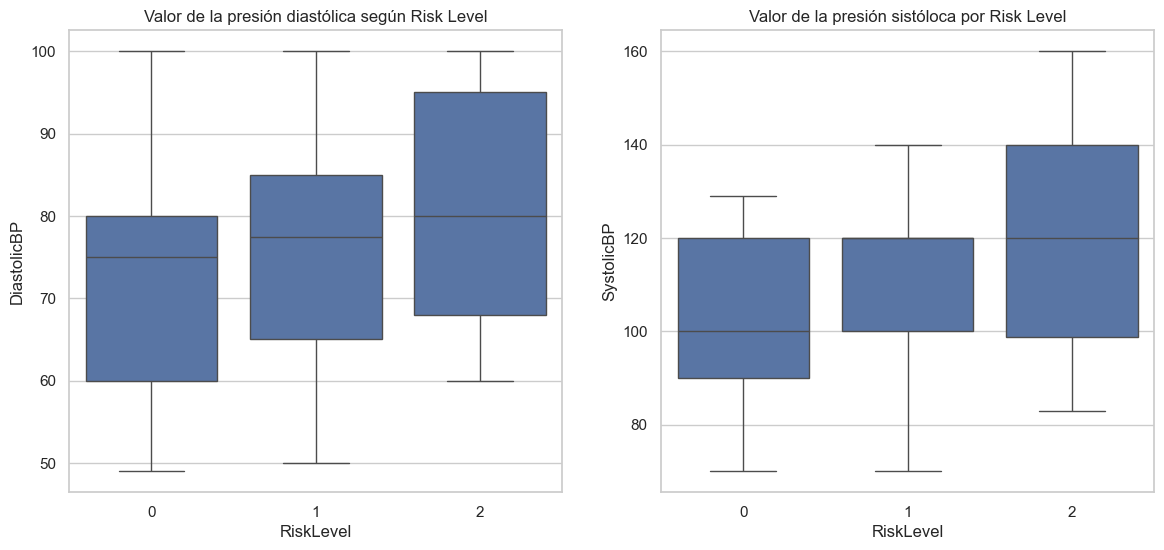

In [136]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,6))

sns.boxplot(ax=axes[0], x=data.RiskLevel, y=data.DiastolicBP)
axes[0].set_title("Valor de la presión diastólica según Risk Level")

sns.boxplot(ax=axes[1], x=data.RiskLevel, y=data.SystolicBP)
axes[1].set_title("Valor de la presión sistóloca por Risk Level")
plt.show()

La relación entre presión arterial y la presión de riesgo, podemos ver que los valores de la presión arterial tienden a incre,entarse a medida que el nivel de riesgo sube. 
Este aumento puede ser un síntoma de hipertensión o preeclampsia, que son factores comunes durante el embarazo. 
Estros patrones sugieren que la presión sistólica y la diastólica son significantes de monitorizar y puedden servir como
un factor predictivo. 

Vemos a ver cómo se distribuye la presión sistólica y diastólica según la edad.

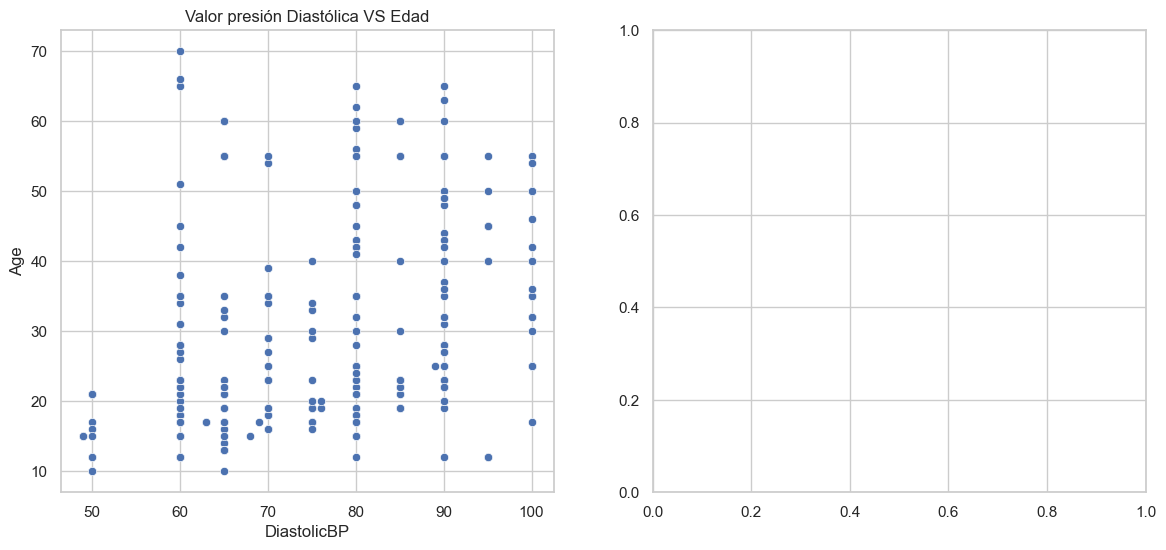

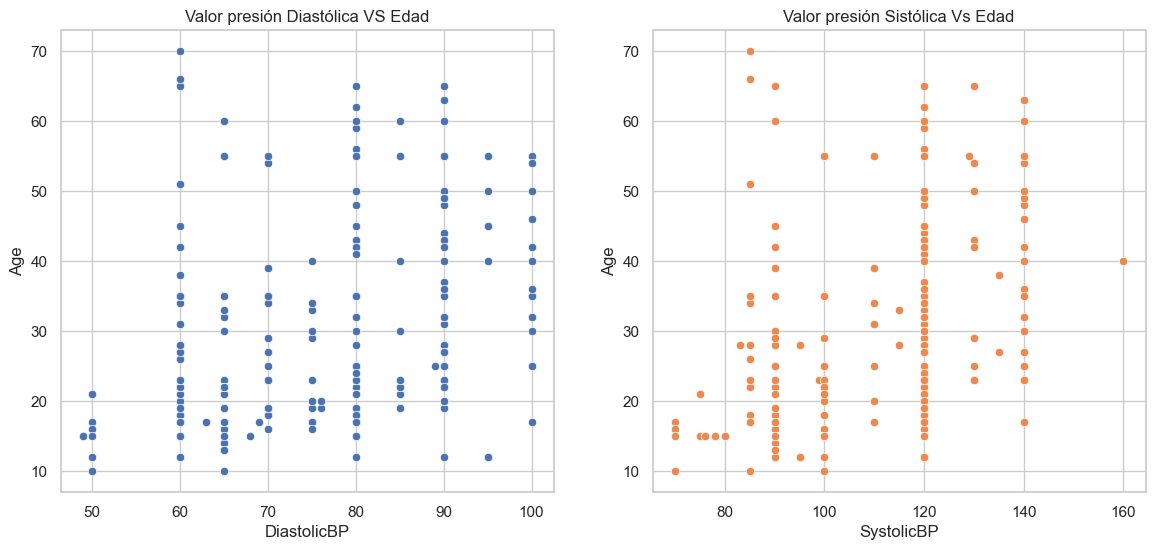

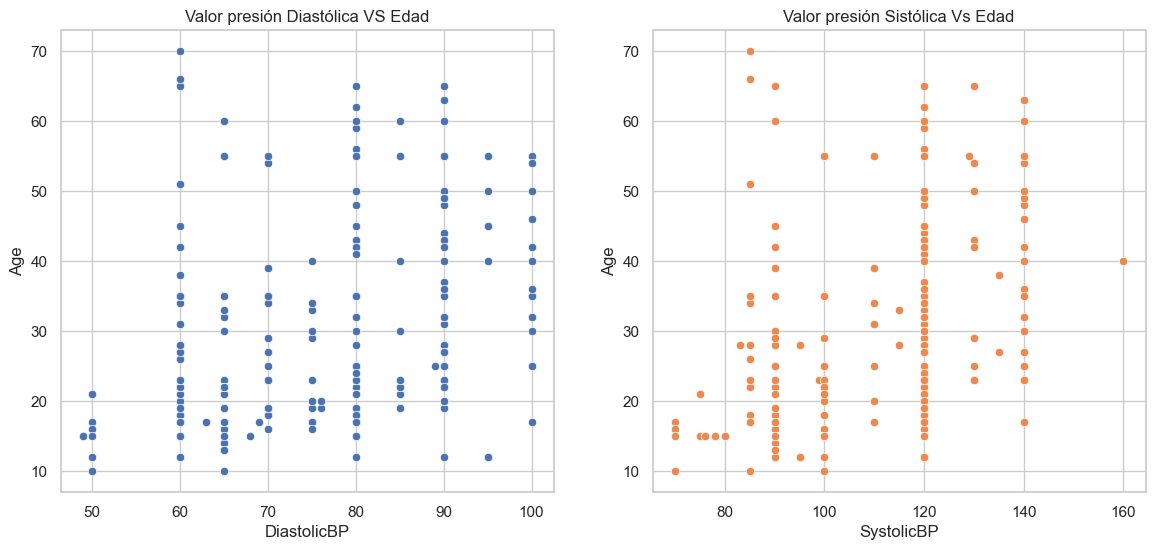

In [146]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
sns.scatterplot(x=data.DiastolicBP, y=data.Age, ax = axes[0])
axes[0].set_title("Valor presión Diastólica VS Edad")

sns.scatterplot(ax=axes[1], x=data.SystolicBP, y = data.Age, color = "#ed894e")
axes[1].set_title("Valor presión Sistólica Vs Edad")
plt.show()

No se  observa ninguna relación entre la edad y la distribución de los valores de la presión diastólica, 
la mayoría de los puntos se encuentran entre los 60 (esta es algo baja, el rango normal es 70) y 90 mmmHg, dentro de un rango  normal. 
Igual ocurre con la gráfica de la presión sistólica según la edad, está en el rango de 90-140 mmHg. A partir de 140 mmHg seconsidere hipertensión; con lo cual la muestra es
normotensa, con una proporción en el rango de prehipertensión (presión sistólica 120-140 mmHg y presión diastólica 80-90 mmHg)


**Body Temperature Vs. Risk Level**

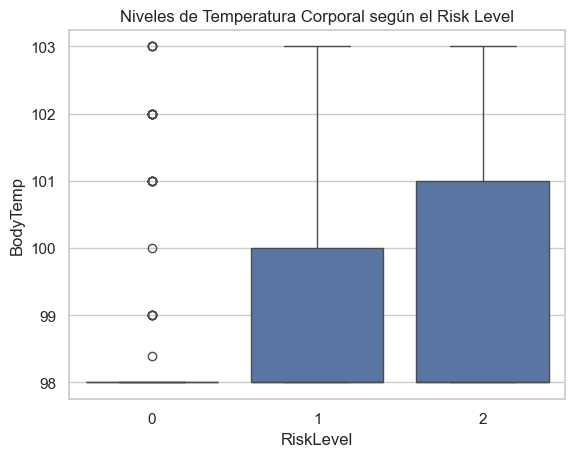

In [152]:
sns.boxplot(x=data.RiskLevel, y=data.BodyTemp).set_title("Niveles de Temperatura Corporal según el Risk Level")
plt.show()

Podemos observar que hay un aumento del nivel de temparatura según aumenta el riesgo, lo que 
sugiere una posible relación entre ambas variables. 

**HeartRate Vs. Risk Level**

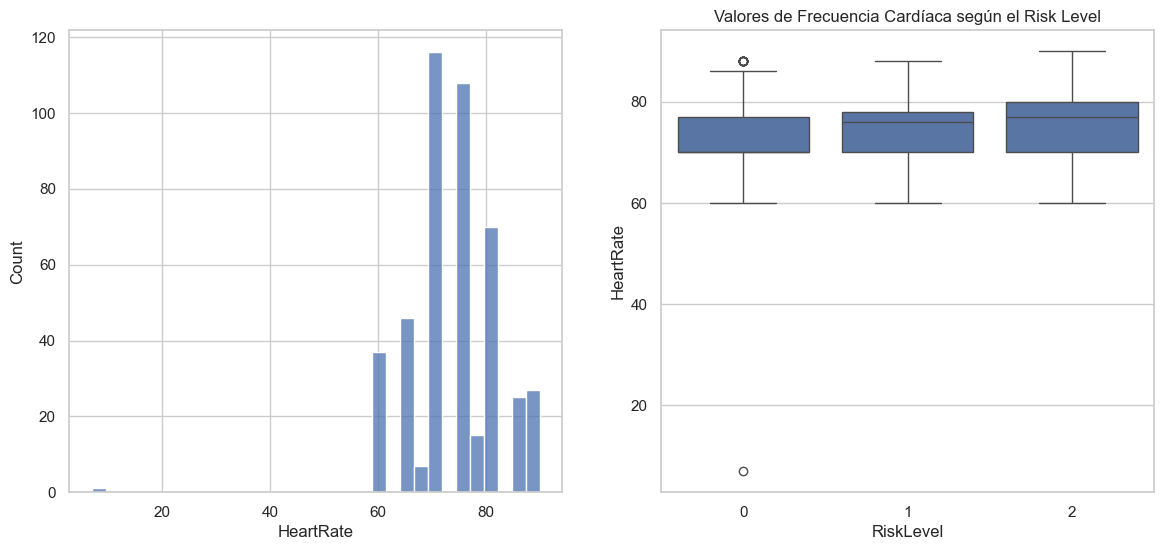

In [160]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
sns.histplot(ax=axes[0], x=data.HeartRate)
sns.boxplot(x=data.RiskLevel, y=data.HeartRate).set_title("Valores de Frecuencia Cardíaca según el Risk Level")
plt.show()

<ol>Distribución general de la frecuencia:
    <li>La mayoría de los valores están concentrados entre 60-80 lpm.</li>
    <li>Muy  pocos valores se encuentran por debajo de 60 lpm y por encima de 80 lpm.</li>
    <li>Hay un valor menor a 20 lpm, que será un outlier a eliminar.</li>
    <li>En general la muestra tiene valores normales de frecuencia cardiaca.</li>
</ol>
<ol>Frecuencia cardíaca según nivel de riesgo:
    <li>No parece  haber ninguna diferencia significativa en la frecuencia cardíaca promedio entre los niveles de riesgo.</li>
</ol>
Esto sugiere que la variable HeartRate  no podría ser usada como valor discriminate por só sola para detectar riegos.

### CONCLUSIONES ANÁLISIS  MUESTRA

<ol>
    <li>Los embarazos de bajo riesgo son los más comunes, ocurriendo en máws de la mitad de los casos.</li>
    <li>Las mujeres jóvenes tienden a tener embarazos de bajo o medio riesgo. Mientras que las mujeres mayores 
    de 35, entre medio y alto riesgo.</li>
    <li>Si una mujer embarazada tiene un nivel de azúcar en sangre superior a 8 mmol/L, el embarazo se considera de riesgo.</li>
    <li>La presión diastólica representa una distribución más añta (60-100 mmHg).</li>
</ol>

## NORMALIZACIÓN DE LA MUESTRA

Como en el notebook mencionado arriba menciona, la asimetría es la distorsión de la distribución de los datos, para la mayoría de los modelos de Machine learning necesitan que los datos estén normalizados. 

Vamos a usar pairplot, es parte de la ibrería Seaborn y permite explorar relaciones entre múltiples variables en un conjunto de datos. En la diagonal principal muestra gráficos de densidad de cada variable, fuera de la diagonal principal muestra relaciones bivariantes. 

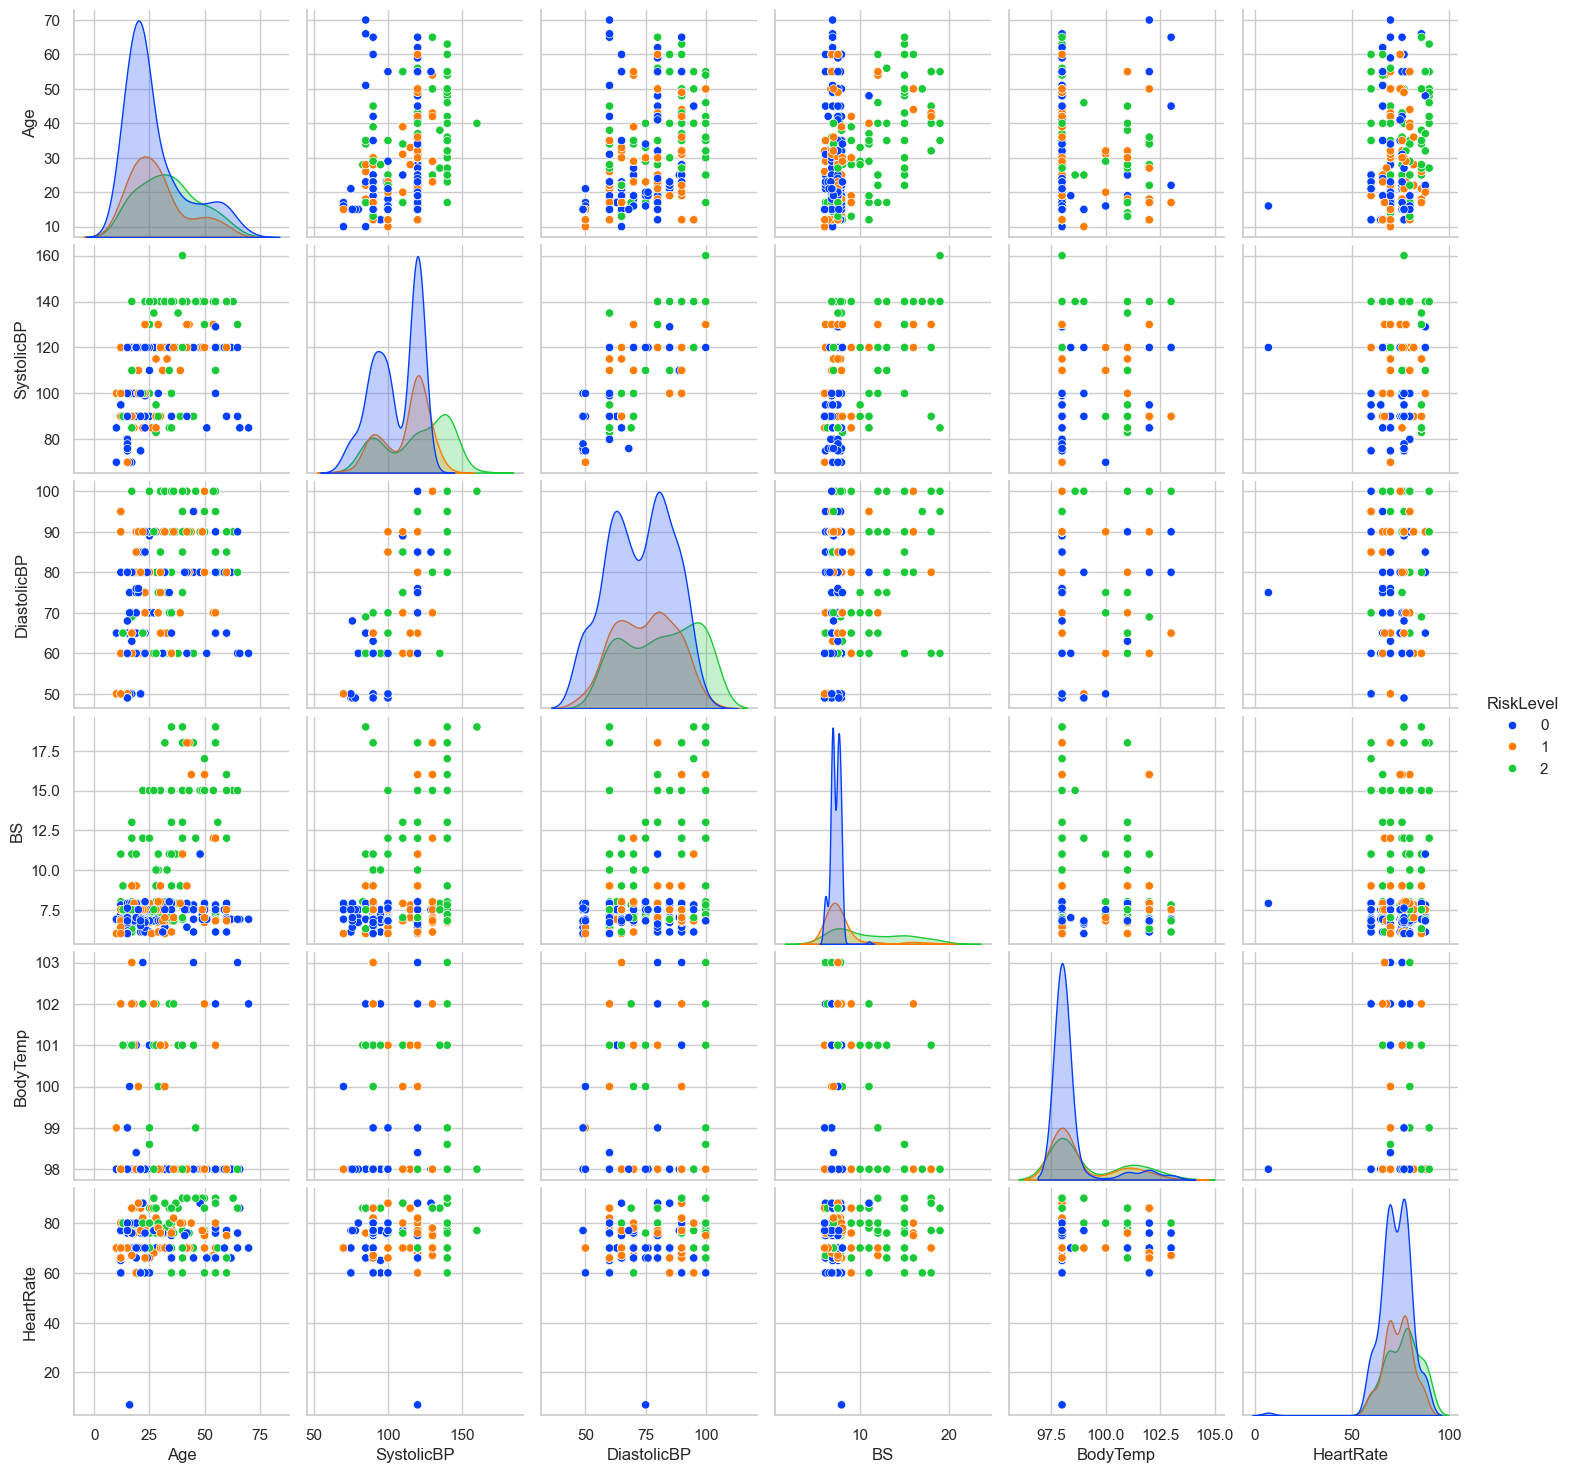

In [195]:
sns.pairplot(data, hue="RiskLevel", diag_kind="kde", palette="bright")
plt.show()

<ol>
    <li>Edad y nivel de riesgo:
    Las mujeres jóvenes tienen mayor proporción de embarazos de bajo riesgo, y las mayores de 35 se relacionan con embarazos de alto riesgo.</li>
    <li>Presión arterial y glucosa:
    Presiones altas (Psistólica > 120 mmHg, Pdiástolica > 80 mmHg) y niveles elevados de glucosa (> 8 mol/L) están relacionados con embarazos de alto riesgo).</li>
    <li>Temperatura y frecuencia cardíaca:
    las mujeres con riesgoalto tienen, general, temperaturas corporales más altas y  frecuencias cardíacas ligeramente elevadas.</li>
<li>Las variables edad, presión arterial, glucosa, temperatura presentan difrenecias claras según el nivel de riesgo, siendo en RisLevel 2 el que concentra las anomalías más marcadas.</li>

Sobre la asimetría:
<ol>
    <li>Las variables BS, BodyTemp y Age: son las más asimétricas con asimetría positiva (curva más larga a la derecha).</li>
    <li>HeartRate: parece las más simétricas. </li>
    <li>SystolicBP y DiastolicBP: tienen asimetría leve positiva</li>
    
</ol>

Vamos a tranformar los datos BS, BodyTemp y Age para que parezcan normalmente distribuidas. 
Transformaciones que vamos a emplear: transformación logarítmica, transformación cuadrada, Box Cox.

In [203]:
df_transformed = data.copy()

#Log transformation
df_transformed["Age"] = data["Age"].apply(np.log)
print(df_transformed["Age"].skew())
sns.displot(df_transformed.Age);

0.197419127736239


BoxCox transformation
Se puede considerar como una generalización de la función raíz cuadrada: la función raíz cuadrada utiliza el exponente de 0,5, pero box cox deja variar su exponente para poder encontrar el mejor.

In [231]:
boxcox_bs, lambda_bs = boxcox(data['BS'])
boxcox_bt, lambda_bt = boxcox(data['BodyTemp'])

#dataframe con resultados transformados:
boxcox_df = pd.DataFrame({
    'BS':boxcox_bs, 
    'BodyTemp':boxcox_bt
})
boxcox_df.head()

,BS,BodyTemp
0,0.299008,0.007562
1,0.298986,0.007562
2,0.298757,0.007562
3,0.298596,0.007562
4,0.298335,0.007562


Asimetría (skew) de BS: 0.264687157371652
Asimetría (skew) de BT: 0.0


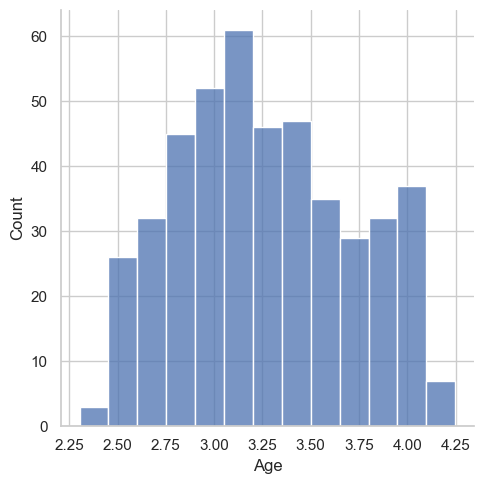

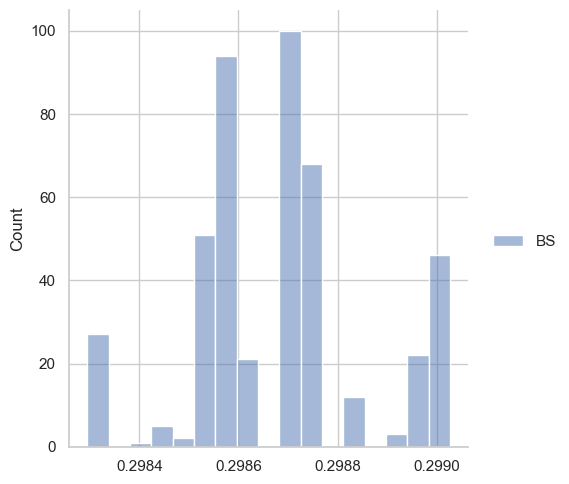

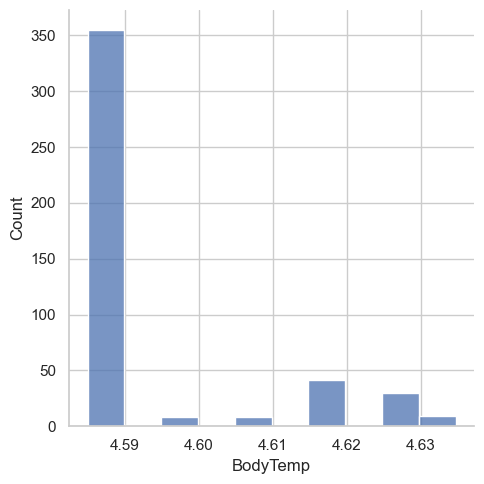

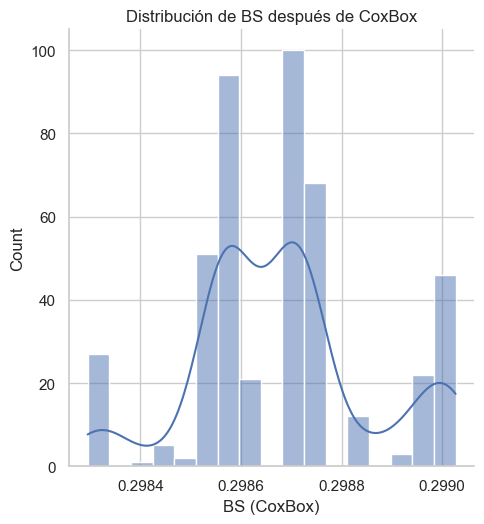

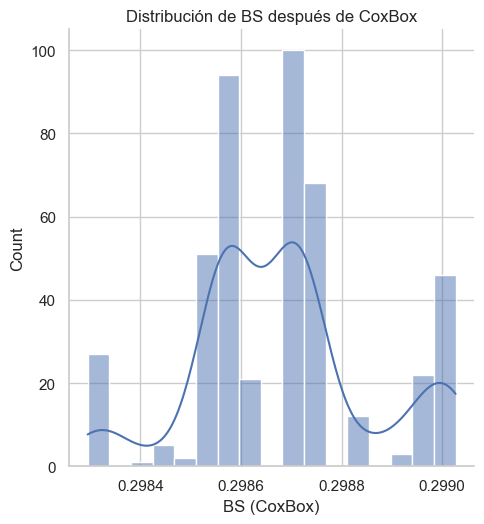

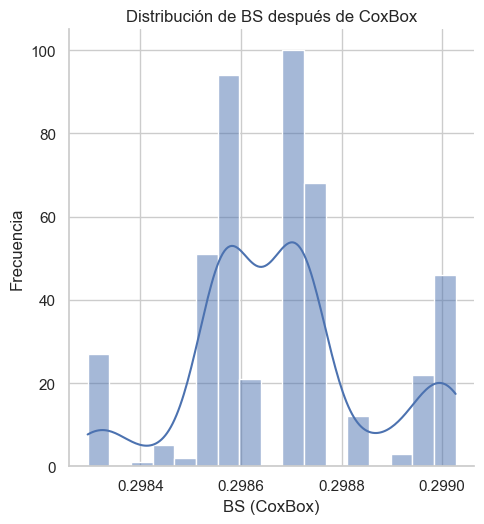

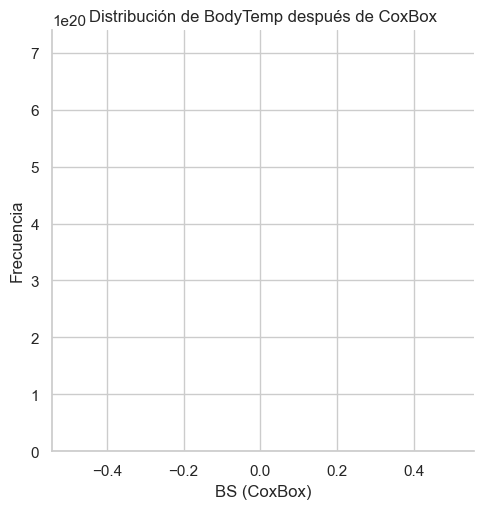

In [243]:
print(f"Asimetría (skew) de BS: {boxcox_df['BS'].skew()}")
print(f"Asimetría (skew) de BT: {boxcox_df['BodyTemp'].skew()}")

sns.displot(boxcox_bs, kde = True)
plt.title("Distribución de BS después de CoxBox")
plt.xlabel("BS (CoxBox)")
plt.ylabel("Frecuencia")
plt.show()

sns.displot(boxcox_bt, kde = True)
plt.title("Distribución de BodyTemp después de CoxBox")
plt.xlabel("BS (CoxBox)")
plt.ylabel("Frecuencia")
plt.show()

Podemos ver que conn la transformación hemosbconseguido que la variable de temperatura corporal esté uniformemente distribuida. 
En cambio la variable BS tiene todavía una ligera asimetría positiva, hay una cola más larga enlos valores superiores a la  mediana. Pero en la curva 
KDE vemos que hay un pico claro, la mayoría de  los valores se concentran en un rango concreto. 

Asimetría de Age tras transformación logaritmíca: 0.197419127736239


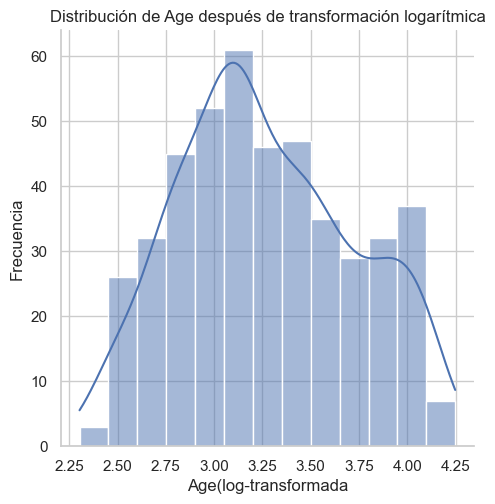

In [253]:
print(f"Asimetría de Age tras transformación logaritmíca: {df_transformed['Age'].skew()}")

#Visualización
sns.displot(df_transformed["Age"], kde=True)
plt.title("Distribución de Age después de transformación logarítmica")
plt.xlabel("Age(log-transformada")
plt.ylabel("Frecuencia")
plt.show()

Como vemos también hemos conseguido que se concentre alrededor del valor de un pico con apenas colas. 

### Separación dec características y objetivo

La variable X tendra las característricas numéricas. 

La variable Y tendrá las etiquetas de la columna RiskLevel.

In [268]:
x = df_transformed.drop('RiskLevel', axis=1)
y = df_transformed['RiskLevel']

## Escalado de las características

Escalamos los datos, para mejorar el rendimiento y estabilidad de los algoritmos de aprendizaje. 
Usando  el <code>StandardScaler</code>transformamos los datos para que tengan una media de 0 una desvaición estándar de 1. 

In [272]:
scaler = StandardScaler()
scaler.fit(x)
XScaled = scaler.transform(x)

## Entrenamiento del modelo

In [279]:
#Separamos datos entre muestra de entrenamiento y muestra de test
X_train, X_test, y_train, y_test = train_test_split(XScaled, y, test_size=0.3, random_state=101, stratify=y)

### KNeighborsClassifier

Modelo de ML para la clasificación supervisada. Clasifica una muestra desconocida basándose en la mayoría de laws clases de sus vecinos más ceracanos en el espacio de características. 
Identifica los K vecinos más cercanos aplicando distancia euclidiana. 

El valor de K (número de vecinos) es importante, pero no se conoce le valor que se ha de poner a priori.
A menor tamaño, menor distancias a caclular y por tanto tarda menos en hacer las predicciones, por eso para este 
algoritmo es importante haberlo escalado previamente. 
Un K muy pequeño lleva a overfitting, un modelo ruidoso, y, un K muy grande suavizada demasiado la clasificación(underfitting). 

In [301]:
#Creamos y ajustamos el modelo
knn=KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

#Hacemos predicciones
knnPreds = knn.predict(X_test)

**Evaluación**

In [323]:
print(f"\nK Nearest Neighbors k = 1\n")
print(confusion_matrix(y_test, knnPreds))
print("\n")
print(classification_report(y_test, knnPreds))


K Nearest Neighbors k = 1

[[64  6  0]
 [24  4  4]
 [ 7  9 18]]


              precision    recall  f1-score   support

           0       0.67      0.91      0.78        70
           1       0.21      0.12      0.16        32
           2       0.82      0.53      0.64        34

    accuracy                           0.63       136
   macro avg       0.57      0.52      0.53       136
weighted avg       0.60      0.63      0.60       136



Para K = 3, vemos que:
<ol>
    <li>la clase 0 tiene un gran desempeño (recall de 0.71), y con una precision del 70%, 
    es decir que hay algunos ejemplos clasificados como clase 1 que no lo son. </li>
    <li>Clase 1 tiene un desempeño muy pobre, en todas las métricas, el algoritmo tiene dificultades 
    para reconocer esta clase.</li>
    <li>La clase 2 tiene la que mejor precisión, aunque el recall muestra que algunos casos de esta clase se pierden.</li>

</ol>

Una de las acciones que se nos ocurre ante este reusltado es ajustar K, también probar 
además de la distancia euclidiana, Manhattan o Minkowski. 

En problemas multiclase, se prueba con valores de K entre 1 y 20. 

Vamos a usar la estrategia basada en Validación cruzada, Cross-validation para probar múltiples valores de K y encontrar 
el que maximice la precisión o reduzca la tasa de error. 

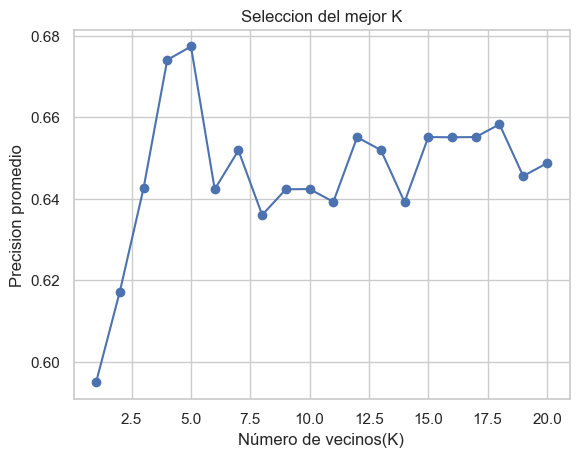

El mejor valor de K es: 5


In [319]:
from sklearn.model_selection import cross_val_score
valoresK = range(1,21) #valores de k a porbar
mean_scores = [] #lista para guardar la pprecisión promedio

for k in valoresK:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    mean_scores.append(np.mean(scores))

plt.plot(valoresK, mean_scores, marker = 'o')
plt.xlabel("Número de vecinos(K)")
plt.ylabel("Precision promedio")
plt.title("Seleccion del mejor K")
plt.show()

best_k = valoresK[np.argmax(mean_scores)]
print(f"El mejor valor de K es: {best_k}")


In [321]:
#Creamos y ajustamos el modelo
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

#Hacemos predicciones
knnPreds = knn.predict(X_test)

In [325]:
print(f"\nK Nearest Neighbors k = 5\n")
print(confusion_matrix(y_test, knnPreds))
print("\n")
print(classification_report(y_test, knnPreds))


K Nearest Neighbors k = 5

[[64  6  0]
 [24  4  4]
 [ 7  9 18]]


              precision    recall  f1-score   support

           0       0.67      0.91      0.78        70
           1       0.21      0.12      0.16        32
           2       0.82      0.53      0.64        34

    accuracy                           0.63       136
   macro avg       0.57      0.52      0.53       136
weighted avg       0.60      0.63      0.60       136



Áún usando el mejor K, para identificar y clasificar la clase 1 sigue siendo muy pobre. 
Podemos probar con otro algoritmo. 

Como vemos, ajustar el valor de K no ha sido suficiente, de esta forma, 
lo que vamos a hacer es hacer uso de Grd search para optimizar los hiperparámetros; nuestro objetivo es que 
la precision de la clase 1 mejore. 

**Configuración de grid search e hiperparámetros:**

Configuración de hiperparámetros:
<ul>
    <li>Modelo base: <code>KNeigborsClassifier</code></li>
    <li>n_neigbors: ajusta el número de vecinos para probar de distintos tamaños.</li>
    <li>weights: <code>'uniform'</code> (todos los vecinos tienen la misma importancia) o <code>'distance'</code> (los vecinos más cercanos tienen más peso).</li>
    <li>metric: <code>'euclidean'</code> (distancia euclidiana), <code>'manhattan'</code> (distancia manhattan), <code>'minkowski'</code> (generalización entre euclidiana y manhattan).</li>
</ul>

Configuración de <code>GridSearch</code>:
<ul>
    <li>cv: divisiones entre las que realiza lavalidación cruzada.</li>
    <li>scoring: tipo de métrica a evaluar (preision, f1, recall, etc.)</li>
    <li>n_jobs: si es -1 usa todos ñps núcleos de la CPU.</li>
</ul>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

param_grid = {
    'n_neighbors': [3, 5, 7, 9],         # Número de vecinos a probar
    'weights': ['uniform', 'distance'], # Ponderación de vecinos
    'metric': ['euclidean', 'manhattan', 'minkowski'] # Métricas de distancia
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

#Ajustamos el modelo
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Precision en validación cruzada con los mejores hiperparámetros:", grid_search.best_params_)

In [ ]:
#Evaluación del modelo en el conjunto de prueba

best_knn = grid_search.best_estimator_
y_pred=best_knn.predict(X_test)
print("Precisión en el conjunto de prueba:", accuracy_score(y_test, y_pred))
print("Reporte de la clasificación:")
print(classification_report(y_test, y_pred))

### Support Vector Machine

Como hemos observado con KNN, hay un desequilibrio de clases y es por eso por lo que 
el algoritmo no es capaz de reconocer la clase 1 correctamente. Para resolver este problema, asignaremos pesos 
a las clases (<code>weights</code>). Como tenemos un total de 452 muestras, de las cuales 234 pertenecen a la clase 0, 
112 a la clase 1 y 106 a la clase 2, vamos a asignar: 0.2, 0.4, 0.4 respectivamente. 

In [343]:
class_weight = {0:0.2, 1:0.4, 2:0.4}

In [345]:
#Creamos y ajustamos modelo SVC

svc = SVC(class_weight=class_weight)
svc.fit(X_train, y_train.values.ravel())

#Hacemos predicciones
svcKernel_pred=svc.predict(X_test)

#Evalúa modelo
print('SVM\n')
print(confusion_matrix(y_test, svcKernel_pred))
print('\n')
print(classification_report(y_test, svcKernel_pred))

SVM

[[60  6  4]
 [18  6  8]
 [ 3  6 25]]


              precision    recall  f1-score   support

           0       0.74      0.86      0.79        70
           1       0.33      0.19      0.24        32
           2       0.68      0.74      0.70        34

    accuracy                           0.67       136
   macro avg       0.58      0.59      0.58       136
weighted avg       0.63      0.67      0.64       136



El modelo clasifica bien la clase 0, y de forma moderada la clase 2, pero
falla significativamente en identificar correctamente los casos de la clase 1. Vamos a probar conn otro algoritmo.

### Random Forest Classifier

Se basa en los modelos de árboles de decisión- 

Construye árboles de decisión independientes cada uno entrenado con un subconjunto del dataset, 
los subconjuntos se crean seleccionado de forma aleatoria muestras del dataset. y cada nodo del árbol tiene un subconjunto de caraxterísticas
seleccionadas aleatoriamente. 

De forma que para clasificar una muestra nuueva, cada árbol hace una predicción, el Random Forest combina las predicciones 
mediante voto mayoritario. 

Configuración de nuestro algoritmo:
<ol>
    <li>n_estimators: nº de árboles en el bosque, probamos con 100, 300, 500.</li>
    <li>criterion:el creiterio  que usamos para medir la calidad de divisiones de los árboles es índice de gini y
    entropía de información</li>
    <li>Profundidad mázima de los árboles: 15, 30, 50.</li>
    <li>min_samples_leaf: nº mínimo de muestras requeridas por hoja: 3, 5, 7.</li>
</ol>

Estos son los datos que probaremos a priori, sin embargo, como hemos hecho antes, 
vamos a aaplicar la estrategia de validación cruzada para buscar la mejor combinación posible. Para esta solución, 
usaremos GridSearchCV, es una tecnica para buscar hiperparámetros usando combinación cruzada para las opciones que hayamos declarado anteriormente. 

In [ ]:
classifier = RandomForestClassifier(class_weight=class_weight)

#Definimos hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 300, 500, 700,1000, 1500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [15, 30, 50, 75, 100, 150],
    'min_samples_split':[2,5,10,15,20],
    'min_samples_leaf': [3, 5, 7, 10,15], 
    'max_features': ['sqrt', 'log2', None, 0.6, 3], 
    'bootstrap': [True, False]
    
    
    }

#creamos objeto GridSearchCV
#Realizamos validación cruzada de 5 particiones (cv = 5)
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print('Mejores parámetros a usar:', grid_search.best_params_)
print('Mejor precisión:', grid_search.best_score_)

#Identificación del mejor modelo
best_forest = grid_search.best_estimator_

In [374]:
forest_pred = grid_search.predict(X_test)

In [376]:
print('Random Forest')
print('\n')
print(confusion_matrix(y_test, forest_pred))
print('\n')
print(classification_report(y_test, forest_pred))

Random Forest


[[59  8  3]
 [15 11  6]
 [ 3  0 31]]


              precision    recall  f1-score   support

           0       0.77      0.84      0.80        70
           1       0.58      0.34      0.43        32
           2       0.78      0.91      0.84        34

    accuracy                           0.74       136
   macro avg       0.71      0.70      0.69       136
weighted avg       0.72      0.74      0.72       136



In [382]:
# Crear un nuevo modelo Random Forest con los mejores parámetros
final_model = RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    max_depth=50,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='log2',
    bootstrap=True,
    random_state=42  # Para reproducibilidad
)

# Entrenar el modelo con los datos de entrenamiento
final_model.fit(X_train, y_train)

# Hacer predicciones con el modelo final
y_pred = final_model.predict(X_test)

# Evaluar el modelo
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.96      0.82        70
           1       0.44      0.12      0.20        32
           2       0.79      0.79      0.79        34

    accuracy                           0.72       136
   macro avg       0.65      0.63      0.60       136
weighted avg       0.67      0.72      0.67       136

